In [1]:
import os
import numpy as np

import scipy.ndimage.morphology as morph

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

from PIL import Image

to_pil = transforms.ToPILImage()
os.listdir('../r_unet/data/')

['images_val', 'labels_val', 'test', 'labels', 'images']

In [2]:
"""
cell_model = {
    'Rnn' : ConvRnnCell(in_channels, out_channels), 
    'Gru' : ConvGruCell(in_channels, out_channels), 
    'Rrn' : ConvRrnCell(in_channels, out_channels), 
    'Sru' : ConvSruCell(in_channels, out_channels), 
    'Dru' : ConvDruCell(in_channels, out_channels)
}
"""
RECURRENT = False
PARAMETERS = {
    'd1':False, 
    'd2':False, 
    'd3':False, 
    'b_':False, 
    'u1':False, 
    'u2':False, 
    'u3':False, 
    'cell_model':'Rnn'
}

DEVICE = "cuda:1"
# arguments
TIMESTEPS = 3
BATCH_SIZE = 1
NUM_EPOCHS = 200
INPUT_SIZE = 128
INPUT_CHANNELS = 1
NUM_CLASSES = 2
LEARNING_RATE = 0.001

transform = transforms.Compose([
                              transforms.Resize((INPUT_SIZE, INPUT_SIZE), interpolation = 0),
                              transforms.ToTensor()
                              ])

to_tensor = transforms.ToTensor()

# decive
device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [3]:
# way to the data folders
FOLDER_DATA = "../r_unet/data/images"
FOLDER_MASK = "../r_unet/data/labels"
FOLDER_TEST = "../r_unet/data/test"
FOLDER_DATA_VAL = "../r_unet/data/images_val"
FOLDER_MASK_VAL = "../r_unet/data/labels_val"

FILE_NAMES = sorted(os.listdir('../r_unet/data/images'))
FILE_NAMES_VAL = sorted(os.listdir('../r_unet/data/images_val'))

In [4]:
def get_labels(object):
    label1 = (object==0).float()
    label2 = (label1==0).float()
    labels = torch.stack([label1, label2], dim=1).squeeze()
    return labels

In [5]:
class TrainMedData(Dataset):
    def __init__(self):
        super().__init__()
        self.time = TIMESTEPS
        self.folder_data = FOLDER_DATA
        self.folder_mask = FOLDER_MASK
        self.file_names = FILE_NAMES

    def __getitem__(self, idx):
        gif_list = []
        for i in range(self.time):
            gif_list.append(transform(Image.open(self.folder_data + '/' + self.file_names[idx+i])))
        gif_data = torch.stack(gif_list)
        gif_list.clear()
        for i in range(self.time):
            gif_list.append(get_labels(transform(Image.open(self.folder_mask + '/' + self.file_names[idx+i]))))
        gif_mask = torch.stack(gif_list)
        gif_list.clear()
        for i in range(self.time):
            img = Image.open(self.folder_mask + '/' + self.file_names[idx+i])
            img = img.resize((INPUT_SIZE, INPUT_SIZE), resample=Image.NEAREST)
            gif_list.append(to_tensor(morph.distance_transform_edt(np.asarray(img)/255)))
        gif_depth = torch.stack(gif_list)
        return gif_data, gif_mask, gif_depth
    
    def __len__(self):
        return len(self.file_names) - self.time + 1


class ValMedData(Dataset):
    def __init__(self):
        super().__init__()
        self.time = TIMESTEPS
        self.folder_data = FOLDER_DATA_VAL
        self.folder_mask = FOLDER_MASK_VAL
        self.file_names = FILE_NAMES_VAL

    def __getitem__(self, idx):
        gif_list = []
        for i in range(self.time):
            gif_list.append(transform(Image.open(self.folder_data + '/' + self.file_names[idx+i])))
        gif_data = torch.stack(gif_list)
        gif_list.clear()
        for i in range(self.time):
            gif_list.append(get_labels(transform(Image.open(self.folder_mask + '/' + self.file_names[idx+i]))))
        gif_mask = torch.stack(gif_list).squeeze(dim=2)
        gif_list.clear()
        for i in range(self.time):
            img = Image.open(self.folder_mask + '/' + self.file_names[idx+i])
            img = img.resize((INPUT_SIZE, INPUT_SIZE), resample=Image.NEAREST)
            gif_list.append(to_tensor(morph.distance_transform_edt(np.asarray(img)/255)))
        gif_depth = torch.stack(gif_list)
        return gif_data, gif_mask, gif_depth

    def __len__(self):
        return len(self.file_names) - self.time + 1


class TestMedData(Dataset):
    def __init__(self):
        super().__init__
        self.time = TIMESTEPS
        self.folder_test = FOLDER_TEST
        self.file_names = FILE_NAMES + FILE_NAMES_VAL

    def __getitem__(self, idx):
        gif_list = []
        for i in range(self.time):
            gif_list.append(transform(Image.open(self.folder_test + '/' + self.file_names[idx+i])))
        gif_test = torch.stack(gif_list)
        gif_list.clear()
        return gif_test

    def __len__(self):
        return len(self.file_names) - self.time + 1

In [6]:
# class TrainMedData(Dataset):
#     def __init__(self):
#         super().__init__()
#         self.time = TIMESTEPS
#         self.folder_data = FOLDER_DATA
#         self.folder_mask = FOLDER_MASK
#         self.file_names = FILE_NAMES

#     def __getitem__(self, idx):
#         gif_list = []
#         for i in range(self.time):
#             gif_list.append(transform(Image.open(self.folder_data + '/' + self.file_names[idx+i])))
#         gif_data = torch.stack(gif_list)
#         gif_list.clear()
#         for i in range(self.time):
#             gif_list.append(get_labels(transform(Image.open(self.folder_mask + '/' + self.file_names[idx+i]))))
#             depth_list = morph.distance_transform_edt(gif_list)
#         gif_mask = torch.stack(gif_list)
#         gif_depth = torch.stack(depth_list)
#         gif_list.clear()
#         depth_list.clear()

#         return gif_data, gif_mask, gif_depth
    
#     def __len__(self):
#         return len(self.file_names) - self.time + 1


# class ValMedData(Dataset):
#     def __init__(self):
#         super().__init__()
#         self.time = TIMESTEPS
#         self.folder_data = FOLDER_DATA_VAL
#         self.folder_mask = FOLDER_MASK_VAL
#         self.file_names = FILE_NAMES_VAL

#     def __getitem__(self, idx):
#         gif_list = []
#         for i in range(self.time):
#             gif_list.append(transform(Image.open(self.folder_data + '/' + self.file_names[idx+i])))
#         gif_data = torch.stack(gif_list)
#         gif_list.clear()
#         for i in range(self.time):
#             gif_list.append(get_labels(transform(Image.open(self.folder_mask + '/' + self.file_names[idx+i]))))
#         gif_mask = torch.stack(gif_list).squeeze(dim=2)
#         gif_list.clear()
#         for i in range(self.time):
#             img = Image.open(self.folder_mask + '/' + self.file_names[idx+i])
#             img = img.resize((INPUT_SIZE, INPUT_SIZE), resample=Image.NEAREST)
#             gif_list.append(to_tensor(morph.distance_transform_edt(np.asarray(img)/255)))
#         gif_depth = torch.stack(gif_list)
#         return gif_data, gif_mask, gif_depth

#     def __len__(self):
#         return len(self.file_names) - self.time + 1


# class TestMedData(Dataset):
#     def __init__(self):
#         super().__init__
#         self.time = TIMESTEPS
#         self.folder_test = FOLDER_TEST
#         self.file_names = FILE_NAMES + FILE_NAMES_VAL

#     def __getitem__(self, idx):
#         gif_list = []
#         for i in range(self.time):
#             gif_list.append(transform(Image.open(self.folder_test + '/' + self.file_names[idx+i])))
#         gif_test = torch.stack(gif_list)
#         gif_list.clear()
#         return gif_test

#     def __len__(self):
#         return len(self.file_names) - self.time + 1

In [7]:
train_dataset = TrainMedData()
valid_dataset = ValMedData()
test_dataset = TestMedData()

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=1,
                          shuffle=False)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=1,
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=1,
                         num_workers=1,
                         shuffle=False)

data_loaders = {
    'train' : train_loader,
    'valid' : valid_loader,
    'test' : test_loader
}

dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(valid_dataset),
    'test': len(test_dataset)
}

In [8]:
x, y, d = train_dataset[0]

In [9]:
y[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [10]:
# to_pil((depth!=0).float())
# depth

In [11]:
# x, y, d = train_dataset[0]
# depth = d[0]
# for dim_0 in depth:
#     for dim_1 in dim_0:
#         Dim_2 = torch.tensor([])
#         for dim_2 in dim_1:
#             if dim_2 == 0:
#                 dim_2 = torch.ones_like(dim_2)
#             torch.cat(dim_2)
# print(Dim_2)

In [12]:
class ConvRnnCell(nn.Module):    
    def __init__(self, in_channels, out_channels):
        super(ConvRnnCell, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels+out_channels, out_channels, kernel_size=3, padding=1))
             
    def forward(self, x, hidden):
        out = torch.cat([x, hidden],dim=1)
        out = self.conv1(out)
        hidden = out
        return out, hidden

In [13]:
class ConvGruCell(nn.Module):    
    def __init__(self, in_channels, out_channels):
        super(ConvGruCell, self).__init__()
        self.conv_for_input = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        
        self.conv_for_hidden = nn.Sequential(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
        
        self.conv_2x_update = nn.Sequential(nn.Conv2d(in_channels+out_channels, out_channels, kernel_size=3, padding=1))
        self.conv_2x_reset = nn.Sequential(nn.Conv2d(in_channels+out_channels, out_channels, kernel_size=3, padding=1))
        
        self.sig = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

     
    def forward(self, x, hidden):
        input = torch.cat([x, hidden],dim=1)

        update_gate = self.conv_2x_update(input)
        update_gate = self.sig((update_gate)) ### output after update gate
        reset_gate = self.conv_2x_reset(input)
        reset_gate = self.sig((reset_gate)) ### output after reset gate
        
        
        memory_for_input = self.conv_for_input(x)
        memory_for_hidden = self.conv_for_hidden(hidden)# просто хидден

        memory_content = memory_for_input + (reset_gate * memory_for_hidden) ### output for reset gate(affects how the reset gate do work)
        memory_content = self.relu(memory_content)

        hidden = (update_gate * hidden) + ((1 - update_gate) * memory_content) # torch.ones(input_size, hidden_size)

        return hidden, hidden

In [14]:
class ConvRrnCell(nn.Module):    
    def __init__(self, in_channels, out_channels):
        super(ConvRrnCell, self).__init__()
        self.conv_for_input = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        
        self.conv_for_hidden = nn.Sequential(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
        
        self.conv_2x_update = nn.Sequential(nn.Conv2d(in_channels+out_channels, out_channels, kernel_size=3, padding=1))
        self.conv_2x_reset = nn.Sequential(nn.Conv2d(in_channels+out_channels, out_channels, kernel_size=3, padding=1))
        
        self.sig = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

     
    def forward(self, x, hidden):
        input = torch.cat([x, hidden],dim=1)

        update_gate = self.conv_2x_update(input)
        update_gate = self.sig((update_gate)) 
        
        memory_for_input = self.conv_for_input(x)
        memory_for_hidden = hidden

        memory_content = memory_for_input + memory_for_hidden
        memory_content = self.relu(memory_content)

        hidden = (update_gate * hidden) + ((1 - update_gate) * memory_content) # torch.ones(input_size, hidden_size)

        return hidden, hidden

In [15]:
class ConvSruCell(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvSruCell, self).__init__()
        self.update_gate = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.backbone = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, hidden):
        z = self.update_gate(x)
        z = self.sig(z)
        
        h_ = self.backbone(x)
        h_ = self.tanh(h_)
        
        h_prev = hidden * z
        h = (1 - z) * h_
        out = h + h_prev
        return out, out

In [16]:
class ConvDruCell(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvDruCell, self).__init__()
        self.update_gate = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.reset_gate = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.backbone = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, hidden):
        z = self.update_gate(x)
        z = self.sig(z)
        
        r = self.reset_gate(x)
        r = self.sig(r)
        rx = r * x
        h_ = self.backbone(rx)
        h_ = self.tanh(h_)
        
        h_prev = hidden * z
        h = (1 - z) * h_
        out = h + h_prev
        return out, out

In [17]:
class ConvRnn(nn.Module):
    def __init__(self, in_channels, out_channels, ConvRnn_input_size, cell_model, reccurent=RECURRENT): # arg for ConvRnn layer
        super(ConvRnn, self).__init__()
        self.cell_dict = {
            'Rnn' : ConvRnnCell(in_channels, out_channels), 
            'Gru' : ConvGruCell(in_channels, out_channels), 
            'Rrn' : ConvRrnCell(in_channels, out_channels), 
            'Sru' : ConvSruCell(in_channels, out_channels), 
            'Dru' : ConvDruCell(in_channels, out_channels)
        }
        self.rec = reccurent
        self.cell_model = cell_model
        self.batch_size = BATCH_SIZE
        self.timesteps = TIMESTEPS
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_size = ConvRnn_input_size
        self.hidden_size = (self.batch_size, self.out_channels, self.input_size, self.input_size)
        
        self.ConvRnn_layer = self.cell_dict[self.cell_model]
        self.init_hidden = torch.zeros(self.hidden_size).to(device)


    def forward(self, x):
        x_cells = None
        x_list = []

        x = x.reshape(self.batch_size, self.timesteps, self.in_channels, self.input_size, self.input_size)
        x = x.permute(1, 0, 2, 3, 4)
        if self.rec == True:
            for i in range(self.timesteps):
                if x_cells is None:
                    x_cells, hidden = self.ConvRnn_layer(x[i], self.init_hidden)
                    x_list.append(x_cells)
                else:
                    x_i, hidden = self.ConvRnn_layer(x[i], hidden)
                    x_list.append(x_i)
        elif self.rec == False:
            for i in range(self.timesteps):
                if x_cells is None:
                    x_cells, _ = self.ConvRnn_layer(x[i], self.init_hidden)
                    x_list.append(x_cells)
                else:
                    x_i, _ = self.ConvRnn_layer(x[i], self.init_hidden)
                    x_list.append(x_i)
        else:
            print('RECURRENT can be only True or False')
            quit()
        x_cells = torch.stack(x_list)
        x_cells = x_cells.permute(1, 0, 2, 3, 4)

        x_cells = x_cells.reshape(-1, self.out_channels, self.input_size, self.input_size)
        return x_cells  

In [18]:
class ConvRnnRelu(nn.Module):
    def __init__(self, in_channels, out_channels ,ConvRnn_input_size, cell_model):
        super(ConvRnnRelu, self).__init__()
        self.cell_model = cell_model
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_size = ConvRnn_input_size
        self.convrnnrelu = nn.Sequential(ConvRnn(self.in_channels, self.out_channels, 
                                                 self.input_size, self.cell_model),
                                         nn.ReLU()
                                         )

    def forward(self, x):
        return self.convrnnrelu(x)

In [19]:
class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvRelu, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.convrelu = nn.Sequential(nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, padding=1),
                                      nn.ReLU()
                                      )

    def forward(self, x):
        return self.convrelu(x)

In [20]:
class MaxPool(nn.Module):
    def __init__(self):
        super(MaxPool, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        return self.maxpool(x)    

In [21]:
class UpAndCat(nn.Module):    
    def __init__(self):
        super(UpAndCat, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x_up, x_cat):
        out = self.up(x_up)
        out = torch.cat([out, x_cat], dim=1)
        return out

In [22]:
class UNetDesigner(nn.Module):    
    def __init__(self, d1, d2, d3, b_, u1, u2, u3, cell_model,
                 input_size=INPUT_SIZE, input_channels=INPUT_CHANNELS, num_classes=NUM_CLASSES):
        super(UNetDesigner, self).__init__()
        self.cell_model = cell_model
        self.num_classes = NUM_CLASSES
        self.d1, self.d2, self.d3, self.b, self.u1, self.u2, self.u3 = d1, d2, d3, b_, u1, u2, u3
        self.input_size = input_size
        self.input_chennels = input_channels
        self.ch_list = [self.input_chennels, 32, 64, 128, 256]
        self.input_x2 = int(self.input_size / 2)
        self.input_x4 = int(self.input_size / 4)
        self.input_x8 = int(self.input_size / 8)

         ##### Down_1 layer ##### input_size = 128
        if self.d1 == True:
            self.down1 = nn.Sequential(ConvRnnRelu(self.ch_list[0], self.ch_list[1],    # Channels
                                                   self.input_size, self.cell_model),               
                                       ConvRelu(self.ch_list[1], self.ch_list[1])                   
                                       )                                                # 1  -->32
        else:                                                                           # 32 -->32
            self.down1 = nn.Sequential(ConvRelu(self.ch_list[0], self.ch_list[1]),
                                       ConvRelu(self.ch_list[1], self.ch_list[1])
                                       )
        self.down1_pool = MaxPool()

         ##### Down_2 layer ##### input_size = 64
        if self.d2 == True:
            self.down2 = nn.Sequential(ConvRnnRelu(self.ch_list[1], self.ch_list[2],
                                                   self.input_x2, self.cell_model),
                                       ConvRelu(self.ch_list[2], self.ch_list[2])
                                       )                                                # 32 -->64
        else:                                                                           # 64 -->64
            self.down2 = nn.Sequential(ConvRelu(self.ch_list[1], self.ch_list[2]),
                                       ConvRelu(self.ch_list[2], self.ch_list[2])
                                       )
        self.down2_pool = MaxPool()

         ##### Down_3 layer ##### input_size = 32
        if self.d3 == True:
            self.down3 = nn.Sequential(ConvRnnRelu(self.ch_list[2], self.ch_list[3], 
                                                   self.input_x4, self.cell_model),
                                       ConvRelu(self.ch_list[3], self.ch_list[3])
                                       )                                                # 64 -->128
        else:                                                                           # 128-->128
            self.down3 = nn.Sequential(ConvRelu(self.ch_list[2], self.ch_list[3]),
                                       ConvRelu(self.ch_list[3], self.ch_list[3])
                                       )
        self.down3_pool = MaxPool()

         ##### Bottom layer ##### input_size = 16
        if self.b == True:
            self.bottom = nn.Sequential(ConvRnnRelu(self.ch_list[3], self.ch_list[4], 
                                                    self.input_x8, self.cell_model),
                                        ConvRelu(self.ch_list[4], self.ch_list[4])
                                        )                                               # 128-->256
        else:                                                                           # 256-->256
            self.bottom = nn.Sequential(ConvRelu(self.ch_list[3], self.ch_list[4]),
                                        ConvRelu(self.ch_list[4], self.ch_list[4])
                                        )

         ##### Up_3 layer #####
        self.up_cat_3 = UpAndCat()
        if self.u3 == True:
            self.up_conv_3 = nn.Sequential(ConvRnnRelu(self.ch_list[4]+self.ch_list[3], 
                                                       self.ch_list[3], 
                                                       self.input_x4, self.cell_model),
                                           ConvRelu(self.ch_list[3], self.ch_list[3])
                                           )                                            # 394-->128
        else:                                                                           # 128-->128
            self.up_conv_3 = nn.Sequential(ConvRelu(self.ch_list[4]+self.ch_list[3], 
                                                    self.ch_list[3]),
                                           ConvRelu(self.ch_list[3], self.ch_list[3])
                                           )

         ##### Up_2 layer #####
        self.up_cat_2 = UpAndCat()
        if self.u2 == True:
            self.up_conv_2 = nn.Sequential(ConvRnnRelu(self.ch_list[3]+self.ch_list[2], 
                                                       self.ch_list[2], 
                                                       self.input_x2, self.cell_model),
                                           ConvRelu(self.ch_list[2], self.ch_list[2])
                                           )                                            # 192-->64
        else:                                                                           # 64 -->64
            self.up_conv_2 = nn.Sequential(ConvRelu(self.ch_list[3]+self.ch_list[2], 
                                                    self.ch_list[2]),
                                           ConvRelu(self.ch_list[2], self.ch_list[2])
                                           )

         ##### Up_1 layer #####
        self.up_cat_1 = UpAndCat()
        if self.u1 == True:
            self.up_conv_1 = nn.Sequential(ConvRnnRelu(self.ch_list[2]+self.ch_list[1], 
                                                       self.ch_list[1], 
                                                       self.input_size, self.cell_model),
                                           ConvRelu(self.ch_list[1], self.ch_list[1])
                                           )                                            # 96 -->32
        else:                                                                           # 32 -->32
            self.up_conv_1 = nn.Sequential(ConvRelu(self.ch_list[2]+self.ch_list[1], 
                                                    self.ch_list[1]),
                                           ConvRelu(self.ch_list[1], self.ch_list[1])
                                           )

         ##### Final layer #####
        self.final = nn.Sequential(nn.Conv2d(self.ch_list[1], self.num_classes, kernel_size=1),

                                   )

    def forward(self, x):
        x = x.reshape(-1, self.input_chennels, self.input_size, self.input_size)
        # print(x.shape)
        down1_feat = self.down1(x)
        pool1 = self.down1_pool(down1_feat)
        # print(pool1.shape)
        down2_feat = self.down2(pool1)
        pool2 = self.down2_pool(down2_feat)
        # print(pool2.shape)
        down3_feat = self.down3(pool2)
        pool3 = self.down3_pool(down3_feat)
        # print(pool3.shape)
        bottom_feat = self.bottom(pool3)
        # print(bottom_feat.shape)
        up_feat3 = self.up_cat_3(bottom_feat, down3_feat)
        up_feat3 = self.up_conv_3(up_feat3)
        
        up_feat2 = self.up_cat_2(up_feat3, down2_feat)
        up_feat2 = self.up_conv_2(up_feat2)
        
        up_feat1 = self.up_cat_1(up_feat2, down1_feat)
        up_feat1 = self.up_conv_1(up_feat1)
        
        out = self.final(up_feat1)
        return out

In [23]:
model = UNetDesigner(d1=PARAMETERS['d1'], 
                     d2=PARAMETERS['d2'], 
                     d3=PARAMETERS['d3'], 
                     b_=PARAMETERS['b_'], 
                     u1=PARAMETERS['u1'], 
                     u2=PARAMETERS['u2'], 
                     u3=PARAMETERS['u3'], 
                     cell_model=PARAMETERS['cell_model']
                     )
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [24]:
def l2_loss(x, y):
    y = y.reshape(x.shape)
    x = F.sigmoid(x)
    out = ((x - y)**2).sum()
    return out

def bce_loss(x, y):
    y = y.reshape(x.shape)
    return F.binary_cross_entropy_with_logits(x, y)

def dice_loss(x, y):
    y = y.reshape(x.shape)
    x = F.sigmoid(x)
    intersection = (x * y).sum(dim=2).sum(dim=2)
    x_sum = x.sum(dim=2).sum(dim=2)
    y_sum = y.sum(dim=2).sum(dim=2)
    dice_loss = 1 - (2*intersection / (x_sum + y_sum))
    return dice_loss.mean()

In [25]:
def combo_loss(x, y, bce_weight=0.7):
    combo_loss = bce_weight * bce_loss(x, y) + (1 - bce_weight) * dice_loss(x, y)
    return combo_loss

In [26]:
def IoU_metric(x, y):
    y = y.reshape(x.shape)
    x = F.sigmoid(x)
    intersection = (x * y).sum(dim=2).sum(dim=2)
    x_sum = x.sum(dim=2).sum(dim=2)
    y_sum = y.sum(dim=2).sum(dim=2)
    IoU_metric = intersection / (x_sum + y_sum - intersection)
    return IoU_metric.mean()

In [31]:
val_loss = []
for epoch in range(1):
    print('*'*10, 'epoch: ', epoch, '*'*10)
    for phase in ['train', 'valid']:
        if phase == 'train':
            loss_list = []
            model.train()
            for i, data in enumerate(data_loaders[phase]):
                input, label, depth = data
                input = input.to(device)
                label = label.to(device)
                depth = depth.to(device)
                output = model(input)
                loss = combo_loss(output, label)
                metric = IoU_metric(output, label)
                loss_list.append(metric.item())
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            mean_loss = sum(loss_list) / len(loss_list)
            print("train l2_norm: ", mean_loss)
        elif phase == 'valid':
            loss_list = []
            model.eval()
            for i, data in enumerate(data_loaders[phase]):
                input, label, depth = data
                input = input.to(device)
                label = label.to(device)
                depth = depth.to(device)
                output = model(input)
                loss = combo_loss(output, label)
                metric = IoU_metric(output, label)
                loss_list.append(metric.item())
            mean_loss = sum(loss_list) / len(loss_list)
            print("val l2_norm: ", mean_loss)
            val_loss.append(mean_loss)
print('Maximum Valid metric: ', max(val_loss))

********** epoch:  0 **********
train l2_norm:  0.9675632552667097
val l2_norm:  0.7232312262058258
Maximum Valid metric:  0.7232312262058258


In [28]:
F.sigmoid(output[0][0][0])

tensor([6.5744e-03, 4.1069e-08, 1.3035e-04, 9.9377e-01, 3.3664e-08, 4.9485e-08,
        1.6379e-05, 3.2565e-07, 1.0370e-07, 1.4981e-05, 1.5260e-04, 4.1498e-06,
        3.1515e-04, 9.4129e-01, 9.9999e-01, 3.1900e-01, 4.4292e-02, 1.3533e-05,
        5.8315e-10, 2.0249e-12, 2.6012e-12, 8.2777e-11, 1.3718e-07, 3.6563e-05,
        4.9031e-04, 1.4759e-01, 1.6839e-01, 6.9871e-05, 4.2509e-05, 9.6579e-01,
        8.6396e-01, 2.3698e-03, 2.8024e-04, 7.9260e-06, 9.5869e-01, 9.1327e-01,
        4.3281e-02, 1.4000e-03, 4.1146e-07, 1.3488e-09, 1.2995e-09, 5.3114e-07,
        1.4341e-06, 5.0619e-05, 4.0442e-03, 3.4320e-01, 7.7201e-03, 7.4873e-06,
        1.2051e-02, 5.7172e-02, 5.7791e-07, 8.1633e-11, 1.6689e-09, 5.6140e-03,
        9.9668e-01, 1.6989e-03, 6.0726e-06, 4.8631e-03, 1.5766e-01, 3.1090e-07,
        3.6138e-10, 3.6080e-09, 6.7405e-09, 6.2810e-06, 3.6996e-02, 9.2955e-01,
        8.4658e-01, 2.6887e-03, 9.0019e-08, 3.6343e-11, 1.9191e-12, 3.5130e-13,
        1.8338e-12, 3.2777e-10, 1.0481e-

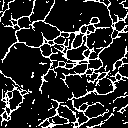

In [29]:
to_pil((output[0][0].cpu()>0).float())

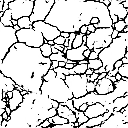

In [30]:
to_pil(F.sigmoid(output[0][1].cpu()))

In [53]:
list_inp = []
list_out = []
for i, data in enumerate(test_loader):
    input = data
    input = input.to(device)
    test_output = model(input)
    list_inp.append(input)
    list_out.append(test_output)

In [113]:
list_inp[0].shape
list_out[0].shape

torch.Size([3, 2, 128, 128])

In [119]:
def showw(object, i):
    imgs = object[i].cpu()
    img = F.sigmoid(imgs[2][1])
    return to_pil(img)

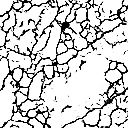

In [120]:
showw(list_out, 0)

In [121]:
from PIL import ImageSequence
index = 3 
for i in range(len(list_out)):
    test_out = showw(list_out, i)
    test_out.save("../r_unet/data/test_output/frame%d.png" % index)
    index += 1